## **Travel time**
This part is used to calculate the travel time from Sumatra earthquake to stations in South Africa and the US.

1. Pick events
2. Pick station
3. Get travel time of the homogeneous sphere model
4. Get waveform for sac
5. Write sac

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import AttribDict
import os
from obspy import read

client = Client("IRIS")

# initial variables for the event
starttime = UTCDateTime("2004-12-26 00:58:53") - 10*60
endtime   = UTCDateTime("2004-12-26 00:58:53") + 10*60
events = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=8.0)
event = events[0]

# event information
print(event.magnitudes[0])
print(event.origins[0])

Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=18508217")
	            mag: 9.0
	 magnitude_type: 'MW'
	  creation_info: CreationInfo(author='HRVD')
Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=3788623")
	          time: UTCDateTime(2004, 12, 26, 0, 58, 52, 50000)
	     longitude: 95.9012
	      latitude: 3.4125
	         depth: 26100.0
	 creation_info: CreationInfo(author='ISC')


## Get station

consider 2 stations:
```
II|SUR|00|BH1
```
```
II|MBAR|00|BH1
```

In [2]:
stations=["AAK","BFO"]
inventories = []
for sta in stations:
    xfactor = client.get_stations(
        starttime=starttime, endtime=endtime, 
        network="II", station=sta,
        location="00", channel="BH*",
        level="response")
    # x[0].plot_response(min_freq=1E-4);
    inventories.append(xfactor)

## Travel time

In [3]:
model = TauPyModel(model="ak135")

degrees = []
for inv in inventories:
    xfactor = locations2degrees(
        lat1 =event.origins[0].latitude,
        long1=event.origins[0].longitude,
        lat2 =inv[0][0].latitude,
        long2=inv[0][0].longitude)
    degrees.append(xfactor)

arrivals = []
for deg in degrees:
    xfactor = model.get_travel_times(
        source_depth_in_km=event.origins[0].depth/1000.,
        distance_in_degree=deg,
        phase_list=["P","pP","S"])
    arrivals.append(xfactor)

print(arrivals[0])
print(arrivals[1])

3 arrivals
	P phase arrival at 482.036 seconds
	pP phase arrival at 489.945 seconds
	S phase arrival at 869.898 seconds
3 arrivals
	P phase arrival at 757.211 seconds
	pP phase arrival at 765.668 seconds
	S phase arrival at 1388.699 seconds


## Wave form

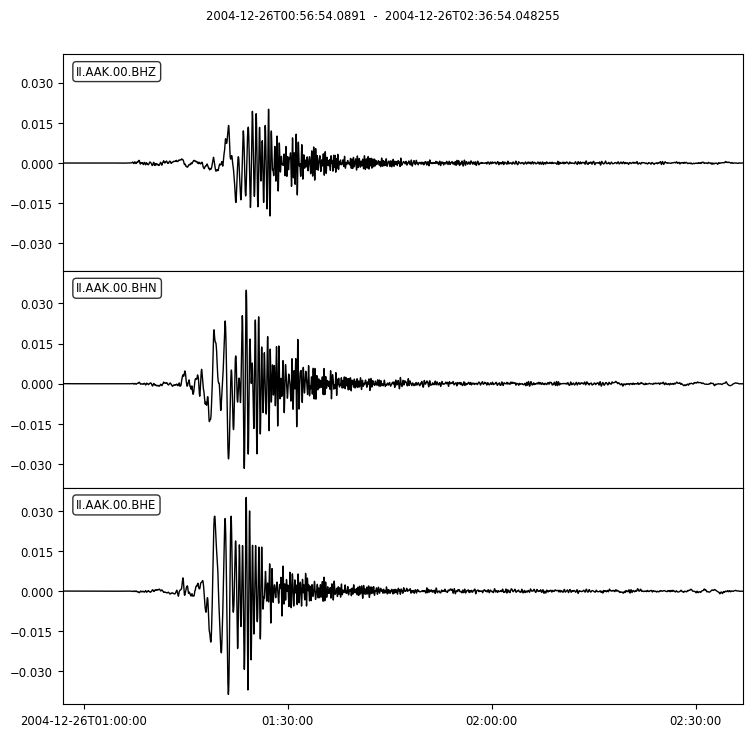

In [4]:
streams = []
for sta in enumerate(stations):
    xfactor = client.get_waveforms(
        starttime=event.origins[0].time+arrivals[0][0].time-60*10,
        endtime  =event.origins[0].time+arrivals[0][0].time+60*90,
        network="II", station="AAK", location="00", channel="BH*",
        attach_response=True)
    xfactor.remove_response(output="DISP")
    streams.append(xfactor)
streams[0].plot();

## Wave path - Example

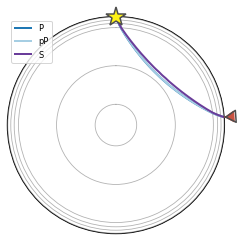

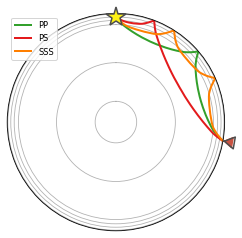

<PolarAxesSubplot:>

In [5]:
arrivals_raypath = model.get_ray_paths(
    source_depth_in_km=event.origins[0].depth/1000.,
    distance_in_degree=degrees[1],
    phase_list=["P","pP","S"])
arrivals_raypath.plot_rays(
    plot_type='spherical',
    phase_list=['PP', 'SSS', 'PS', 'P'],
    plot_all=False, legend=True)

model_example = TauPyModel(model='iasp91')
arrivals_raypath = model_example.get_ray_paths(200, 100, phase_list=['PP', 'SSS', 'PS'])
arrivals_raypath.plot_rays(plot_type='spherical',
                   phase_list=['PP', 'SSS', 'PS', 'P'],
                   plot_all=False, legend=True)

## Matplotlib

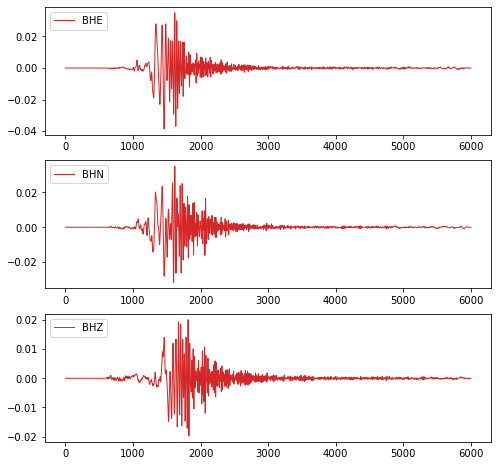

In [6]:
plt.figure(figsize=(8,8))
for i, trace in enumerate(streams[0]):
    j = i + 1
    time = np.arange(trace.stats.npts)*trace.stats.delta
    channel = trace.stats.channel
    plt.subplot(int(str(31)+str(j)))
    plt.plot(time, trace.data, color='tab:red', linewidth=1, label=str(channel))
    plt.legend(loc=2)

## SAC

In [7]:
sacd=AttribDict()
sacd.evla = event.origins[0].latitude
sacd.evlo = event.origins[0].longitude
sacd.evdp = event.origins[0].depth/1000.
sacd.mag  = event.magnitudes[0].mag
event_id = str(event.origins[0].time.date)+"T"+\
    str(event.origins[0].time.hour)+"-"+\
    str(event.origins[0].time.minute)+"-"+\
    str(event.origins[0].time.second)

if not os.path.exists("sac-obspy"):
    os.mkdir("sac-obspy")

for i, inv in enumerate(inventories):
    sacd.stla = inv[0][0].latitude
    sacd.stlo = inv[0][0].longitude
    sacd.t0   = arrivals[i][0].time
    if not os.path.exists("sac-obspy/"+stations[i]):
        os.mkdir("sac-obspy/"+stations[i])
    for trace in streams[i]:
        trace.stats.sac = sacd
        trace.write("sac-obspy/"+stations[i]+"/"+event_id+'_'
                +trace.stats.station+'_'+trace.stats.channel+'.SAC',
                format='SAC')